In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'


import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import haiku as hk

# the metaaf package
import metaaf

## Make The Dataset

When you make a metaaf dataset, you write a vanilla pytorch dataset. The dataset should not use jax and must return a dictionary with the keys "signals" and "metadata". We enforce this format since the "signals" are automatically segmented and buffered. In this example, we make a simple system identification dataset which returns signals but not metadata.

In [2]:
from torch.utils.data import Dataset

# write a vanilla pytorch dataset
class SystemIDDataset(Dataset):
    def __init__(self, total_size=2048, N=4096, sys_order=32):
        self.N = N
        self.sys_order = sys_order
        self.total_size = total_size

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        # the system
        w = np.random.normal(size=self.sys_order) / self.sys_order

        # the input
        u = np.random.normal(size=self.N)

        # the output
        d = np.convolve(w, u)[: self.N]

        # metaaf datasets MUST return a dictionary with two parts
        # "signals" which will be automatically buffered
        # "metadata" which is managed by the user
        return {
            "signals": {
                "u": u[:, None],  # time X channels
                "d": d[:, None],
            },  # time X channels
            "metadata": {},
        }

## Make The Filter

The filter is what gets fits to an incoming signal. Metaaf provides wrapper code for a variety of common STFT processing pipelines such a Overlap-Save, Overlap-Add and Weighted Overlap-Add. You can also write your own and use our buffering framework. All filters are written in haiku. When using our wrapper code, the filter much return a dictionary with an "out" key. This is what gets used by later STFT processing.

In [3]:
from metaaf.filter import OverlapSave

# the filter inherits from the overlap save modules
class SystemID(OverlapSave, hk.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # select the analysize window
        self.analysis_window = jnp.ones(self.window_size)

    # Since we use the OLS base class, x and y are stft domain inputs.
    # The filter msut take the same inputs provided in its _fwd function.
    def __ols_call__(self, u, d, metadata):
        # collect a buffer sized anti-aliased filter
        w = self.get_filter(name="w")

        # this is n_frames x n_freq x channels or 1 x F x 1 here
        y = w * u
        e = y - d

        return {
            "out": y[0],
            "u": u,
            "d": d,
            "e": e,
            "y": y,
            "grad": jnp.conj(u)
            * e,  # Can also provide the gradient manually since its easy to compute
            "loss": jnp.vdot(e, e).real / (e.size),  # the MSE of the prediction
        }


# Haiku converts objects to functions. We need to provide a wrapper to do this.
# The wrapper function MUST take as input the same named values from your dataset.
def _SystemID_fwd(u, d, metadata=None, init_data=None, **kwargs):
    gen_filter = SystemID(**kwargs)
    return gen_filter(u=u, d=d)


# We also need to define the filter loss
def filter_loss(out, data_samples, metadata):
    return out["loss"]


# A meta training loss
def meta_train_loss(
    losses, outputs, data_samples, metadata, outer_index, outer_learnable
):
    out = jnp.concatenate(outputs["out"], 0)
    EPS = 1e-9
    return jnp.log(jnp.mean(jnp.abs(out - data_samples["d"]) ** 2) + EPS)


# And a meta validation loss
def meta_val_loss(losses, outputs, data_samples, metadata, outer_learnable):
    out = jnp.reshape(
        outputs["out"],
        (outputs["out"].shape[0], -1, outputs["out"].shape[-1]),
    )
    d = data_samples["d"]

    min_len = min(out.shape[1], d.shape[1])

    EPS = 1e-9
    return jnp.log(jnp.mean(jnp.abs(out[:, :min_len] - d[:, :min_len]) ** 2) + EPS)

# Setup a Meta Trainer

Next, we setup all filter keyword arguments. These will be used by the OLS baseclass to correctly buffer inputs and run the online STFT processing. These can also be done via argparse, since all metaaf modules have argparse utilities. Here, we use dictionaries for simplicity.

In [4]:
from metaaf.data import NumpyLoader

# Prep any filter arguments. These are going to be STFT processing parameters
filter_kwargs = {
    "n_frames": 1,
    "n_in_chan": 1,
    "n_out_chan": 1,
    "window_size": 64,
    "hop_size": 32,
    "pad_size": 0,
    "is_real": True,
}

# Prep any optimizer arguments
optimizer_kwargs = {
    "h_size": 16,
    "n_layers": 1,
    "lam_1": 1e-2,
    "input_transform": "log1p",
}

# And initialize our dataloaders using the custom numpyloader wrapper
train_loader = NumpyLoader(SystemIDDataset(total_size=1024), batch_size=32)
val_loader = NumpyLoader(SystemIDDataset(total_size=128), batch_size=32)
test_loader = NumpyLoader(SystemIDDataset(total_size=128), batch_size=32)

Now, we create a metaaf system. This system manages the training and will later provide inference utilities. We need to pass it the forward functions, losses, keyword arguments as well as the dataloaders. We'll set some optimizer options. For more advanced functionality, we can write our own forward passes, overridde other options, and even pass in training callbacks. These could do things like save checkpoints, log outputs, and more.

In [5]:
from metaaf.meta import MetaAFTrainer

system = MetaAFTrainer(
    _filter_fwd=_SystemID_fwd,
    filter_kwargs=filter_kwargs,
    filter_loss=filter_loss,
    meta_train_loss=meta_train_loss,
    meta_val_loss=meta_val_loss,
    optimizer_kwargs=optimizer_kwargs,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
)

# Train!

Finally, we can train the system. Simply run system.train and pass in training parameters such as the optimizer, learning rate, early stopping information, and more.

In [6]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

outer_learned, (train_loss, val_loss) = system.train(
    total_epochs=21, val_period=10, key=subkey
)

Total of - 1905 - Trainable Parameters


Epoch Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Loop:   0%|          | 0/32 [00:00<?, ?it/s]

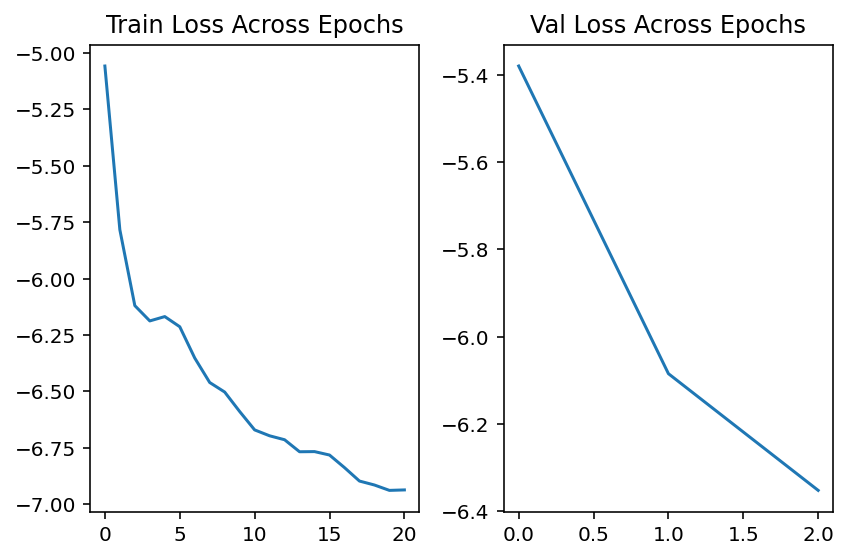

In [7]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(train_loss.mean(1))
ax[0].set_title("Train Loss Across Epochs")

ax[1].plot(val_loss)
ax[1].set_title("Val Loss Across Epochs")

plt.tight_layout()
plt.show()

# Using a Trained Model

## Offline Mode
Once training has finished, the metaaf system has functionality for both batch and online inference. For batch inference, we can just use the system.infer function and pass in the current data as well as the final learned parameters. It will return the predictions as well as other auxilliary outputs like losses, additional filter outputs, and the final filter state.

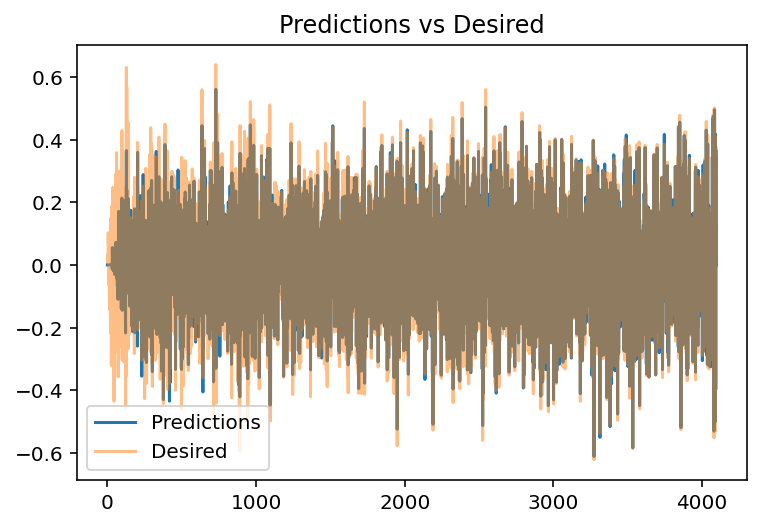

In [8]:
data = next(iter(system.val_loader))
data_dict = {"u": data["signals"]["u"][0:1], "d": data["signals"]["d"][0:1]}

offline_pred, aux = system.infer({"signals": data_dict, "metadata": {}}, outer_learned)
outer_loss, inner_loss, extra_outs, final_state = aux


plt.plot(offline_pred[0, :, 0], label="Predictions")
plt.plot(data_dict["d"][0, :, 0], alpha=0.5, label="Desired")
plt.legend()
plt.title("Predictions vs Desired")
plt.show()

## Online Mode

For online inference, the metaaf system can generate an online_step function and an initial state. We can use this online_step function by passing in hop_size inputs chunks form some audio buffer.

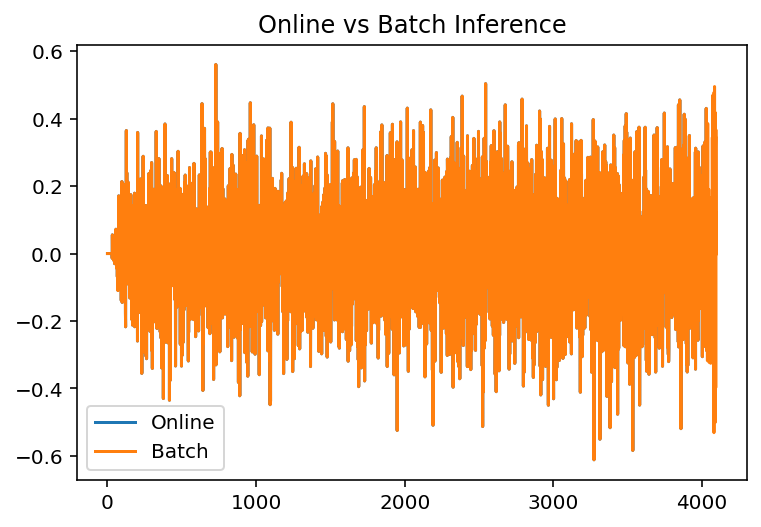

In [9]:
online_step, state = system.make_online_infer(outer_learned)
hop_size = filter_kwargs["hop_size"]

preds = []
for i in range(0, len(data["signals"]["u"][0]) - 2 * hop_size, hop_size):
    cur_data = {
        "signals": {
            "u": data["signals"]["u"][0, i : i + hop_size],
            "d": data["signals"]["d"][0, i : i + hop_size],
        },
        "metadata": {},
    }
    pred, loss, state = online_step(state, batch=cur_data, key=jax.random.PRNGKey(0))

    preds.append(pred["out"])
preds = np.array(preds).flatten()

plt.plot(preds, label="Online")
plt.plot(offline_pred[0, :, 0], label="Batch")
plt.title("Online vs Batch Inference")
plt.legend()
plt.show()

## Inspecting The Filter Parameters

We can also inspect the filter parameters. Here, we plot the final filter along with the true system.

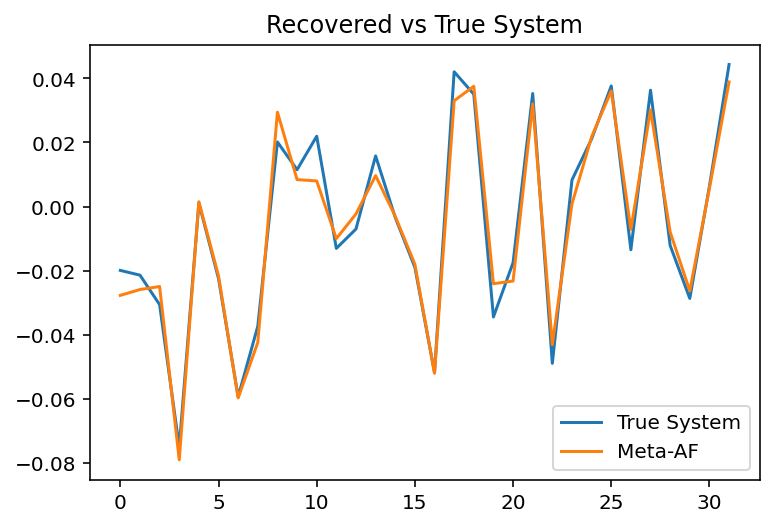

In [10]:
w = np.random.normal(size=32) / 32
u = np.random.normal(size=2048)
d = np.convolve(w, u)[: len(u)]

data_dict = {"u": u[None, :, None], "d": d[None, :, None]}

offline_pred, aux = system.infer({"signals": data_dict, "metadata": {}}, outer_learned)
outer_loss, inner_loss, extra_outs, final_state = aux

w_hat = jnp.fft.irfft(jax.tree_util.tree_flatten(final_state[1])[0][0][0][0, :, 0])
w_hat = w_hat[: len(w_hat) // 2]

plt.plot(w, label="True System")
plt.plot(w_hat, label="Meta-AF")
plt.title("Recovered vs True System")
plt.legend()
plt.show()